In [1]:
!pip3 install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=85c9dc7e6e2c409ce20109e09ddd08b7dc03c0f3a3ad4d9367fbff9c0e4ab642
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=2c3cc47889df51211d5b2082247f585be817eb7312403b2d9d8dd470e3f5be6f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
import os
import torch
import torchvision as tv
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from PIL import Image

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
class RoadModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

        self.train_metrics = []
        self.valid_metrics = []
        self.test_metrics = []

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.optimizer = self.configure_optimizers()

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):        
        image = batch[0].to(device)

        if stage == 'train':
            self.train()
        if stage == 'valid' or stage == 'test':
            self.eval()

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1].to(device)

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0
        
        self.optimizer.zero_grad()
        logits_mask = self.forward(image)
        self.optimizer.step()
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        if stage == 'train':
            self.training_step_outputs.append({"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn})
        elif stage == 'valid':
            self.validation_step_outputs.append({"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn})
        elif stage == 'test':
            self.test_step_outputs.append({"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn})

        return loss

    def shared_epoch_end(self, stage):
        # aggregate step metics

        if stage == 'train':
            tp = torch.cat([x["tp"] for x in self.training_step_outputs])
            fp = torch.cat([x["fp"] for x in self.training_step_outputs])
            fn = torch.cat([x["fn"] for x in self.training_step_outputs])
            tn = torch.cat([x["tn"] for x in self.training_step_outputs])
        elif stage == 'valid':
            tp = torch.cat([x["tp"] for x in self.validation_step_outputs])
            fp = torch.cat([x["fp"] for x in self.validation_step_outputs])
            fn = torch.cat([x["fn"] for x in self.validation_step_outputs])
            tn = torch.cat([x["tn"] for x in self.validation_step_outputs])
        elif stage == 'test':
            tp = torch.cat([x["tp"] for x in self.test_step_outputs])
            fp = torch.cat([x["fp"] for x in self.test_step_outputs])
            fn = torch.cat([x["fn"] for x in self.test_step_outputs])
            tn = torch.cat([x["tn"] for x in self.test_step_outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        if stage == 'train':
            self.train_metrics.append(dataset_iou)
        if stage == 'valid':
            self.valid_metrics.append(dataset_iou)
        if stage == 'test':
            self.test_metrics.append(dataset_iou)
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def on_train_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [4]:
class RoadsTrainset(Dataset):
    def __init__(self, transforms = tv.transforms.ToTensor()) -> None:
        super().__init__()

        self.image_path = '/kaggle/input/massachusetts-roads-dataset/tiff/train/'
        self.label_path = '/kaggle/input/massachusetts-roads-dataset/tiff/train_labels/'
        
        self.images = os.listdir(self.image_path)
        self.labels = os.listdir(self.label_path) 

        for i in range(len(self.images)):
            self.images[i] = transforms(Image.open(self.image_path + self.images[i]))
            self.labels[i] = transforms(Image.open(self.label_path + self.labels[i]))
        
        #self.files_processed = primary_range

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        #return super().__getitem__(index)
        return self.images[index], self.labels[index]

class RoadsValidset(Dataset):
    def __init__(self, transforms = tv.transforms.ToTensor()) -> None:
        super().__init__()

        self.image_path = '/kaggle/input/massachusetts-roads-dataset/tiff/val/'
        self.label_path = '/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/'

        self.images = os.listdir(self.image_path)
        self.labels = os.listdir(self.label_path)

        for i in range(len(self.images)):
            self.images[i] = transforms(Image.open(self.image_path + self.images[i]))
            self.labels[i] = transforms(Image.open(self.label_path + self.labels[i]))

            if i % 200 == 0:
                print(i, 'files for valid set passed')

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        #return super().__getitem__(index)
        return self.images[index], self.labels[index]
    
class RoadTestset(Dataset):
    def __init__(self, transforms = tv.transforms.ToTensor()) -> None:
        super().__init__()

        self.image_path = '/kaggle/input/massachusetts-roads-dataset/tiff/test/'
        self.label_path = '/kaggle/input/massachusetts-roads-dataset/tiff/test_labels/'

        self.images = os.listdir(self.image_path)
        self.labels = os.listdir(self.label_path)

        for i in range(len(self.images)):
            self.images[i] = transforms(Image.open(self.image_path + self.images[i]))
            self.labels[i] = transforms(Image.open(self.label_path + self.labels[i]))

            if i % 200 == 0:
                print(i, 'files for test set passed')

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        #return super().__getitem__(index)
        return self.images[index], self.labels[index]

In [5]:
def create_sets():
    if 'train_dataset' in os.listdir('./'):
        train_dataset = torch.load('train_dataset')
    else:
        train_dataset = RoadsTrainset(transforms=transforms)
        torch.save(train_dataset, 'train_dataset')

    if 'valid_dataset' in os.listdir('./'):
        valid_dataset = torch.load('valid_dataset')
    else:
        valid_dataset = RoadsValidset(transforms=transforms)
        torch.save(valid_dataset, 'valid_dataset')

    if 'test_set' in os.listdir('./'):
        test_dataset = torch.load('test_dataset')
    else:
        test_dataset = RoadTestset(transforms=transforms)
        torch.save(test_dataset, 'test_dataset')

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
    valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=10, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

    return train_dataloader, valid_dataloader, test_dataloader

def steps():
    trainer.fit(
        model, 
        train_dataloaders=train_dataloader, 
        val_dataloaders=valid_dataloader,
    )
    trainer.test(
        model,
        test_dataloader
    )

In [6]:
transforms = tv.transforms.Compose([tv.transforms.ToTensor(),
                                    tv.transforms.Resize([576, 576])])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_dataloader, valid_dataloader, test_dataloader = create_sets()
model = RoadModel("FPN", "resnet34", in_channels=3, out_classes=1)
model.to(device)

trainer = pl.Trainer( 
    max_epochs=40,
)
steps()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0 files for valid set passed
0 files for test set passed


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 73.3MB/s]


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_dataset_iou      │   0.038103897124528885    │
│    test_per_image_iou     │   0.038103897124528885    │
└───────────────────────────┴───────────────────────────┘

In [11]:
img = (train_dataloader.dataset[1][0] - model.mean) / model.std
mask = train_dataloader.dataset[1][1]
out = model.model(img)
        
img = img.cpu().numpy()[0]
mask = mask.numpy()
out = out.detach().numpy()[0]

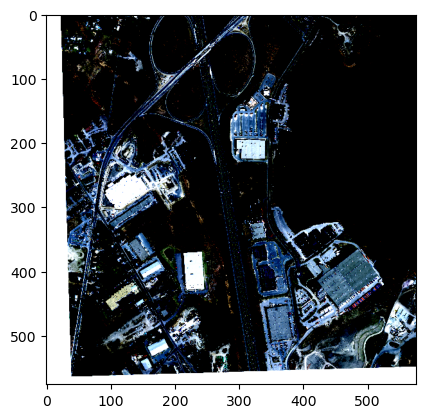

In [12]:
import matplotlib.pyplot as plt
plt.imshow(img.transpose(1, 2, 0))

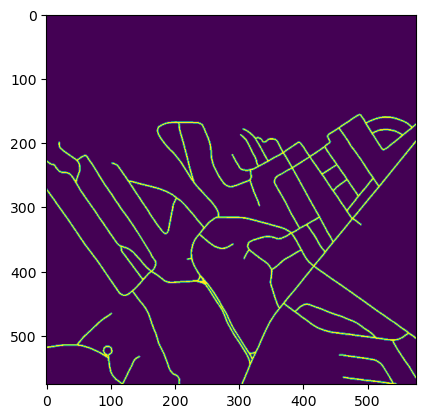

In [13]:
plt.imshow(mask.transpose(1, 2, 0))

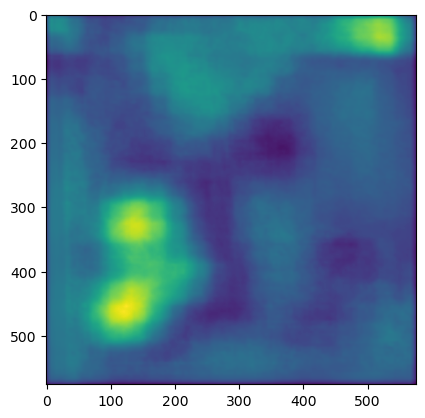

In [14]:
plt.imshow(out.transpose(1, 2, 0))